Reading instruments SDA 

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import os 
import glob 
import math 
import pynmea2
import re 
from scipy import signal
import shutil

%matplotlib widget


In [3]:
#data directory
data_dir = 'D:/PICCOLO/data/CO2 flux system'

In [8]:
#data directory 
#data_dir = 'C:/Users/ENV/OneDrive - Plymouth Marine Laboratory/vscode/EC_co2_flux/EC flux processing/SDA_IMC/data_piccolo_sample'

Make CR6 files hourly , only need to run once 

In [ ]:

def process_cr6_hourly_data(input_path, output_path):
    """
    Process CR6 data files to group and filter data by hour,
    saving output files in a single directory.
    
    Args:
    input_path (str): Directory containing CR6 data files
    output_path (str): Directory to save processed hourly files
    """
    # Ensure output directory exists
    os.makedirs(output_path, exist_ok=True)
    
    # Collect all .dat files in the input directory
    data_files = [f for f in os.listdir(input_path) if f.endswith('.dat') and f.startswith('CR6data_')]
    
    # Process each file
    for filename in data_files:
        try:
            # Read the file, skipping the first header row
            df_raw = pd.read_csv(
                os.path.join(input_path, filename), 
                skiprows=1, 
                delimiter=','
            )
            
            # Remove unnecessary rows and reset the index
            df_raw = df_raw.iloc[2:].reset_index(drop=True)

            # Convert 'TIMESTAMP' column to datetime and set as index
            df_raw['TIMESTAMP'] = pd.to_datetime(
                df_raw['TIMESTAMP'], 
                format='%Y-%m-%d %H:%M:%S.%f', 
                errors="coerce"
            )
            df_raw = df_raw.set_index('TIMESTAMP')

            # Skip if no valid timestamps
            if df_raw.empty or df_raw.index.empty:
                print(f"No valid timestamps in {filename}")
                continue

            # Define the range for valid hourly data
            start_hour = df_raw.index.min().floor('h')
            end_hour = df_raw.index.max().ceil('h')

            # Filter data to exclude non-hourly records 
            df_filtered = df_raw.loc[
                ~((df_raw.index < start_hour) & (df_raw.index.minute == 59)) & 
                (df_raw.index <= end_hour)
            ].copy()

            # Logging and additional checks
            print(f"Processing file: {filename}")
            print(f"Total records: {len(df_raw)}")
            print(f"Filtered records: {len(df_filtered)}")
            print(f"First timestamp: {df_filtered.index.min()}")
            print(f"Last timestamp: {df_filtered.index.max()}")

            # Skip if no data after filtering
            if df_filtered.empty:
                print(f"No valid hourly data in {filename}")
                continue

            # Process each unique hour in the filtered data
            for hour in df_filtered.index.floor('h').unique():
                # Filter data for this specific hour
                df_hour = df_filtered.loc[
                    (df_filtered.index >= hour) & 
                    (df_filtered.index < hour + timedelta(hours=1))
                ]

                # Create output filename using the hour
                output_filename = f"CR6_Processed_{hour.strftime('%Y%m%d_%H%M%S')}.dat"
                output_file = os.path.join(output_path, output_filename)

                # Prepare column names based on the original header
                column_names = [
                    'SonicX', 'SonicY', 'SonicZ', 'SonicT', 
                    'RotX', 'RotY', 'RotZ', 
                    'AccX', 'AccY', 'AccZ', 
                    'ShipSonicX', 'ShipSonicY', 'ShipSonicZ', 'ShipSonicT'
                ]

                # Reset index to include timestamp as a column
                df_output = df_hour.reset_index()
                
                # Ensure we only keep specified columns (or use all columns if not enough specified)
                columns_to_keep = ['TIMESTAMP'] + column_names[:len(df_output.columns)-1]
                df_output = df_output[columns_to_keep]

                # Write processed data
                df_output.to_csv(
                    output_file, 
                    sep='\t', 
                    index=False, 
                    
                    na_rep='NaN'
                )
                
                print(f"Processed hourly data to {output_file}")

        except Exception as e:                     
            print(f"Error processing {filename}: {e}")                                                     
            continue


# Example usage
input_base_path = 'D:/PICCOLO/data/CO2 flux system/CR6'
output_base_path = 'D:/PICCOLO/data/CO2 flux system/CR6_hourly'
process_cr6_hourly_data(input_base_path, output_base_path)

Processing file: CR6data_2024_01_17_0000.dat
Total records: 36000
Filtered records: 32400
First timestamp: 2024-01-17 00:00:00.600000
Last timestamp: 2024-01-17 01:00:00.500000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240117_000000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240117_010000.dat
Processing file: CR6data_2024_01_17_0100.dat
Total records: 36000
Filtered records: 32400
First timestamp: 2024-01-17 01:00:00.600000
Last timestamp: 2024-01-17 02:00:00.500000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240117_010000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240117_020000.dat
Processing file: CR6data_2024_01_17_0200.dat
Total records: 35999
Filtered records: 32399
First timestamp: 2024-01-17 02:00:00.600000
Last timestamp: 2024-01-17 03:00:00.400000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_

C:\Users\ENV\AppData\Local\Temp\ipykernel_7272\2175487319.py:20: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(


Processing file: CR6data_2024_01_17_2300.dat
Total records: 72004
Filtered records: 64804
First timestamp: 2024-01-17 23:00:00.300000
Last timestamp: 2024-01-18 01:00:00.600000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240117_230000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240118_000000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240118_010000.dat
Processing file: CR6data_2024_01_18_0100.dat
Total records: 35999
Filtered records: 32399
First timestamp: 2024-01-18 01:00:00.700000
Last timestamp: 2024-01-18 02:00:00.500000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240118_010000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240118_020000.dat
Processing file: CR6data_2024_01_18_0200.dat
Total records: 35999
Filtered records: 32399
First timestamp: 2024-01-18 02:00:00.600000
La

C:\Users\ENV\AppData\Local\Temp\ipykernel_7272\2175487319.py:20: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(


Processing file: CR6data_2024_02_02_1057.dat
Total records: 397631
Filtered records: 357867
First timestamp: 2024-02-02 10:57:16.900000
Last timestamp: 2024-02-02 21:59:59.900000
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_100000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_110000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_120000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_130000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_140000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_150000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_160000.dat
Processed hourly data to D:/PICCOLO/data/CO2 flux system/CR6_hourly\CR6_Processed_20240202_170000.dat
Proce

Make picarro files hourly

In [ ]:
def process_hourly_data(input_path, output_path):
    """
    Process data files to ensure they contain complete hourly data,
    with improved memory efficiency.
    """
    os.makedirs(output_path, exist_ok=True)
    
    # Process files in batches of 24 hours (1 day)
    all_files = []
    for root, _, files in os.walk(input_path):
        all_files.extend([os.path.join(root, f) for f in files 
                         if f.endswith('.dat') and 'DataLog_User_Sync' in f])
    
    # Sort files by name to process them chronologically
    all_files.sort()
    
    # Process in 24-file batches
    batch_size = 24
    for i in range(0, len(all_files), batch_size):
        batch_files = all_files[i:i+batch_size]
        file_data = {}
        
        print(f"Processing batch {i//batch_size + 1} of {math.ceil(len(all_files)/batch_size)}")
        
        # Read batch of files
        for file_path in batch_files:
            try:
                # Read only necessary columns
                df = pd.read_csv(file_path, sep='\s+', header=0,
                               usecols=['DATE', 'TIME', 'FRAC_DAYS_SINCE_JAN1', 
                                      'FRAC_HRS_SINCE_JAN1', 'JULIAN_DAYS', 
                                      'EPOCH_TIME', 'ALARM_STATUS', 'INST_STATUS',
                                      'CavityPressure_sync', 'CavityTemp_sync', 
                                      'DasTemp_sync', 'EtalonTemp_sync', 
                                      'WarmBoxTemp_sync', 'species_sync',
                                      'MPVPosition_sync', 'OutletValve_sync', 
                                      'solenoid_valves_sync', 'CH4_sync',
                                      'CH4_dry_sync', 'CO2_sync', 'CO2_dry_sync', 
                                      'H2O_sync'])
                
                df['datetime'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
                df = df.drop(['DATE', 'TIME'], axis=1)
                
                file_data[file_path] = {
                    'df': df,
                    'start': df['datetime'].min(),
                    'end': df['datetime'].max()
                }
                
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue
        
        # Process each hour in the batch
        batch_hours = set()
        for data in file_data.values():
            start_hour = data['start'].floor('h')
            end_hour = data['end'].floor('h')
            current = start_hour
            while current <= end_hour:
                batch_hours.add(current)
                current += timedelta(hours=1)
        
        for hour in sorted(batch_hours):
            next_hour = hour + timedelta(hours=1)
            hour_data = []
            
            for data in file_data.values():
                if (data['start'] <= next_hour and data['end'] >= hour):
                    df = data['df']
                    mask = (df['datetime'] >= hour) & (df['datetime'] < next_hour)
                    hour_data.append(df[mask])
            
            if not hour_data:
                continue
                
            df_combined = pd.concat(hour_data, ignore_index=True)
            df_combined = df_combined.drop_duplicates().sort_values('datetime')
            
            output_filename = f"CFHADS2041-{hour.strftime('%Y%m%d')}-{hour.strftime('%H%M%S')}Z-DataLog_User_Sync.dat"
            output_file = os.path.join(output_path, output_filename)
            
            df_combined.to_csv(output_file, sep='\t', index=False)
            print(f"Processed hourly data to {output_file}")
        
        # Clear batch data from memory
        del file_data
        
# Use existing input and output paths
process_hourly_data(input_base_path, output_base_path)


Run at the start 

In [4]:
#get filenames in raw data files

def file_name_dir(data_dir):
    """
    get the raw EC data file names and directories

    input:  the parent directory of the raw EC data
    return: the EC data file names (_name) and directories(_dir)
    
    """    

    cr6_name = os.listdir(data_dir + '\\CR6_hourly')
    GPS_name = [f for f in os.listdir(data_dir + '\\Underway') if 'gps' in f]
    HDG_name = [f for f in os.listdir(data_dir + '\\Underway') if 'hdg' in f]
    metek_name = os.listdir(data_dir + '\\Metek')
    cr800_name = os.listdir(data_dir + '\\CR800')
    Picarro_name = os.listdir(data_dir + '\\picarro_hourly')

 
    return cr6_name,GPS_name,HDG_name, metek_name,cr800_name,Picarro_name

In [5]:
#creates lists of files to be processed 
cr6_name,GPS_name, HDG_name,metek_name,cr800_name,Picarro_name = file_name_dir(data_dir)

In [6]:
def extract_timestamp(filename):
    """Extract timestamp from different filename formats and return a datetime object."""
    patterns = [
        r"(\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}Z)",  # Format: 2024-01-30T01-00-00Z
        r"CR6_Processed_(\d{8}_\d{6})",  # Format: CR6_Processed_20240130_010000.dat
        r"(\d{8}\d{4})",  # Format: 202401300100COM2.txt
        r"(\d{4}_\d{2}_\d{2}_\d{4})",  # Format: Waterwatcher_2024_01_30_0600.dat
        r"CFHADS2041-(\d{8}-\d{6})Z"  # Format: CFHADS2041-20240117-060000Z-DataLog_User_Sync
    ]

    for pattern in patterns:
        match = re.search(pattern, filename)
        if match:
            ts_str = match.group(1)
            
            # Define matching formats for each pattern
            formats = [
                "%Y-%m-%dT%H-%M-%SZ",  # 2024-01-30T01-00-00Z
                "%Y%m%d_%H%M%S",  # 20240130_010000
                "%Y%m%d%H%M",  # 202401300100
                "%Y_%m_%d_%H%M",  # 2024_01_30_0600
                "%Y%m%d-%H%M%S"  # 20240117-060000
            ]

            for fmt in formats:
                try:
                    return datetime.strptime(ts_str, fmt)
                except ValueError:
                    continue
                    
    return None


In [7]:
# Extract dates from each file list into sets
cr6_dates = [extract_timestamp(filename) for filename in cr6_name]
picarro_dates = [extract_timestamp(filename) for filename in Picarro_name]
GPS_dates = [extract_timestamp(filename) for filename in GPS_name]
HDG_dates = [extract_timestamp(filename) for filename in HDG_name]
metek_dates = [extract_timestamp(filename) for filename in metek_name]

# Find common dates
common_dates = set(picarro_dates) & set(cr6_dates) & set(GPS_dates) & set(HDG_dates) & set(metek_dates)








In [8]:
# Convert common_dates to list and sort for consistent ordering
common_dates_list = sorted(list(common_dates))

# Filter filenames for each data source to only include common dates
cr6_name = [filename for filename in cr6_name 
            if extract_timestamp(filename) in common_dates]

GPS_name = [filename for filename in GPS_name 
            if extract_timestamp(filename) in common_dates]

HDG_name = [filename for filename in HDG_name 
            if extract_timestamp(filename) in common_dates]

metek_name = [filename for filename in metek_name 
              if extract_timestamp(filename) in common_dates]

Picarro_name = [filename for filename in Picarro_name 
                if extract_timestamp(filename) in common_dates]



In [9]:
#make new folder to store the processed data
new_folder_path = os.path.join(data_dir, "L0_test")

# Create the new folder
os.makedirs(new_folder_path, exist_ok=True)

# subfolders to create
subfolders = ["TimeAdjGases", "PML_WindsForMotcorr", "Ship_WindsForMotcorr"]

# subfolder inside "L0"
for subfolder in subfolders:
    os.makedirs(os.path.join(new_folder_path, subfolder), exist_ok=True)


Functions to read raw data files 

In [69]:
#read underway.gps files
def read_gps_data(filename):
    """
    Reads an NMEA file and extracts datetime, latitude, longitude, and speed.
    """
    data = {
        'datetime': [],
        'latitude': [],
        'longitude': [],
        'speed': []
    }
    
    with open(os.path.join(data_dir, 'Underway', filename)) as file:
        for line in file:
            try:
                # Split timestamp from NMEA sentence
                timestamp_str, nmea = line.strip().split(' $')
                nmea = '$' + nmea
                timestamp = pd.to_datetime(timestamp_str)
                
                if "INVTG" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.spd_over_grnd_kts:
                        speed = float(msg.spd_over_grnd_kts)
                        data['datetime'].append(timestamp)
                        data['speed'].append(speed)
                        data['latitude'].append(None)
                        data['longitude'].append(None)
                        
                elif "INGGA" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.latitude and msg.longitude:
                        lat = round(msg.latitude,6)
                        lon = round(msg.longitude,6)
                        if msg.lat_dir == 'S':
                            lat = -lat
                        if msg.lon_dir == 'W':
                            lon = -lon
                        data['datetime'].append(timestamp)
                        data['latitude'].append(lat)
                        data['longitude'].append(lon)
                        data['speed'].append(None)
                        
            except (ValueError, pynmea2.ParseError) as e:
                continue

    df = pd.DataFrame(data)
    df = df.set_index('datetime')  # Assign the result back to df
    df.index = df.index.tz_localize(None)
    return df

In [68]:
#read underway.hdg.txt
def read_hdg_data(filename):
    data = {
        'datetime': [],
        'heading': [],
        'rate_of_turn': []
    }
    
    with open(os.path.join(data_dir, 'Underway', filename)) as file:
        for line in file:
            try:
                timestamp_str, nmea = line.strip().split(' $')
                nmea = '$' + nmea
                timestamp = pd.to_datetime(timestamp_str)
                
                if "INHDT" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.heading:
                        heading = float(msg.heading)
                        data['datetime'].append(timestamp)
                        data['heading'].append(heading)
                        data['rate_of_turn'].append(None)
                      
                elif "INROT" in nmea:
                    msg = pynmea2.parse(nmea)
                    if msg.rate_of_turn:
                        rot = float(msg.rate_of_turn)
                        data['datetime'].append(timestamp)
                        data['heading'].append(None)
                        data['rate_of_turn'].append(rot)
                
                        
            except (ValueError, pynmea2.ParseError) as e:
                continue

    
    df = pd.DataFrame(data)
    df = df.set_index('datetime')  # Assign the result back to df
    df.index = df.index.tz_localize(None)
    return df


Wind data 

In [67]:
def read_cr6_data(filename):
    df = pd.read_csv(os.path.join(data_dir, 'CR6_hourly', filename),  delimiter='\t')
    df = df.iloc[2:].reset_index(drop=True)
    # Convert TIMESTAMP to datetime and set as index
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f', errors="coerce")
    df = df.set_index('TIMESTAMP')

    rad2deg = 180.0 / np.pi

    # Convert columns to numeric, replacing empty strings with NaN
    numeric_cols = ['SonicX', 'SonicY', 'SonicZ', 'SonicT',
                    'ShipSonicX', 'ShipSonicY', 'ShipSonicZ', 'ShipSonicT',
                    'RotX', 'RotY', 'RotZ', 'AccX', 'AccY', 'AccZ']
    
    for col in numeric_cols:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Calculate wind components
    result_df = pd.DataFrame(index=df.index)
    result_df['u_ms'] = df['SonicY'] / 100.0
    result_df['v_ms'] = df['SonicX'] / -100.0
    result_df['w_ms'] = df['SonicZ'] / 100.0
    result_df['t_degC'] = df['SonicT'] / 100.0
    
    result_df['u_ms_ship'] = df['ShipSonicY'] / 100.0
    result_df['v_ms_ship'] = df['ShipSonicX'] / -100.0
    result_df['w_ms_ship'] = df['ShipSonicZ'] / 100.0
    result_df['t_degC_ship'] = df['ShipSonicT'] / 100.0

    # Rotation and Acceleration
    result_df['rotx_degs'] = rad2deg * df['RotX'] / 1000.0
    result_df['roty_degs'] = rad2deg * df['RotY'] / 1000.0
    result_df['rotz_degs'] = rad2deg * df['RotZ'] / 1000.0
    result_df['accelx_g'] = df['AccX'] / -1000.0
    result_df['accely_g'] = df['AccY'] / -1000.0
    result_df['accelz_g'] = df['AccZ'] / -1000.0
    
    def despike_column(series, sigma_threshold=5):
        """
        Remove spikes from a time series using sigma-based method
        
        Parameters:
        -----------
        series : pandas.Series
            Input time series to despike
        sigma_threshold : float, optional
            Number of standard deviations to use as threshold (default: 5)
        
        Returns:
        --------
        pandas.Series
            Despiked time series with spikes replaced by NaN
        """
        # Calculate mean and standard deviation
        v_avg = series.mean()
        v_sdev = series.std()
        
        # Create a mask for non-spike values
        mask = np.abs(series - v_avg) < sigma_threshold * v_sdev
        
        # Return series with spikes replaced by NaN
        return series * mask
    
    # Apply despiking to relevant columns
    despike_columns = [
        'u_ms', 'v_ms', 'w_ms', 't_degC', 
        'u_ms_ship', 'v_ms_ship', 'w_ms_ship', 't_degC_ship',
        'rotx_degs', 'roty_degs', 'rotz_degs', 
        'accelx_g', 'accely_g', 'accelz_g'
    ]
    
    for col in despike_columns:
        result_df[col] = despike_column(result_df[col])

    return result_df



Water watcher

In [ ]:
def read_cr800_data(filename):
    df = pd.read_csv(os.path.join(data_dir, 'cr800', filename), skiprows=1, delimiter=',')
    df = df.iloc[2:].reset_index(drop=True)
    # Convert TIMESTAMP to datetime and set as index
    df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], format='mixed')
    # Convert all non-datetime columns to float
    for col in df.columns:
        if col != "TIMESTAMP":
            df[col] = pd.to_numeric(df[col])
    df = df.set_index("TIMESTAMP")  # Set the timestamp as index
    df = df.iloc[:,3:]  # Select columns after index 3
    
    return df

Metek

In [65]:

def read_metek_data (filename):

    # Create regex patterns for both formats (M: and H:)
    patterns = {
        'M': re.compile(r'(?P<datetime>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}Z)\s+M:x =\s+(?P<x>-?\d+)\s+y =\s+(?P<y>-?\d+)\s+z =\s+(?P<z>-?\d+)\s+t =\s+(?P<t>-?\d+)'),
        'H': re.compile(r'(?P<datetime>\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{6}Z)\s+H:x =\s+(?P<x>-?\d+)\s+y =\s+(?P<y>-?\d+)\s+z =\s+(?P<z>-?\d+)\s+t =\s+(?P<t>-?\d+)')
    }

    # Determine which pattern to use by checking first line
    with open(os.path.join(data_dir, 'Metek', filename)) as file:
        first_line = file.readline()
        pattern = patterns['M'] if 'M:x' in first_line else patterns['H']

    # Read and process lines
    data = []
    with open(os.path.join(data_dir, 'Metek', filename)) as file:
        for line in file:
            match = pattern.search(line)
            if match:
                data.append(match.groupdict())

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Convert data types
    df["datetime"] = pd.to_datetime(df["datetime"])  
    df["x"] = df["x"].astype(float)
    df["y"] = df["y"].astype(float)
    df["z"] = df["z"].astype(float)
    df["t"] = df["t"].astype(float)

    df["x"] = df["x"]/ -100.0
    df["y"] = df["y"]/ 100.0
    df["z"] = df["z"] / 100.0
    df["t"] = df["t"]/ 100.0


    # Set datetime as index
    df.set_index("datetime", inplace=True)  
    df.index = df.index.tz_localize(None)
    

    def despike_column(series, sigma_threshold=5):
            """
            Remove spikes from a time series using sigma-based method
            
            Parameters:
            -----------
            series : pandas.Series
                Input time series to despike
            sigma_threshold : float, optional
                Number of standard deviations to use as threshold (default: 5)
            
            Returns:
            --------
            pandas.Series
                Despiked time series with spikes replaced by NaN
            """
            # Calculate mean and standard deviation
            v_avg = series.mean()
            v_sdev = series.std()
            
            # Create a mask for non-spike values
            mask = np.abs(series - v_avg) < sigma_threshold * v_sdev
            
            # Return series with spikes replaced by NaN
            return series * mask
        
        # Apply despiking to relevant columns
    despike_columns = [
            'x', 'y', 'z', 't']
            
        
    for col in despike_columns:
        df[col] = despike_column(df[col])
        
    return df

Picarro data 

In [66]:
def read_picarro_data(filename):
    df = pd.read_csv(os.path.join(data_dir, 'picarro_hourly', filename), sep='\t')
    df['datetime'] = pd.to_datetime(df['datetime'])

    # drop date and time columns
    df.set_index('datetime', inplace=True) 
    #add true and false value 
    #df_picarro['puff'] = df_picarro['solenoid_valve'] != 0 in data it is 32 fro some reason?     
    return df

Once there is a df for each hourly file:

Lag time 

In [ ]:
def lag_time(df_cr6, df_metek, cr6_col='v_ms', metek_col='x', max_lag_seconds=300):
    """
    Calculate the lag time between two time series using maximum covariance.
    
    Parameters:
    -----------
    df_cr6 : pandas.DataFrame
        DataFrame with datetime index containing CR6 data
    df_metek : pandas.DataFrame
        DataFrame with datetime index containing Metek data
    cr6_col : str, optional
        Column name in df_cr6 to use for comparison (default: 'v_ms')
    metek_col : str, optional
        Column name in df_metek to use for comparison (default: 'x')
    max_lag_seconds : int, optional
        Maximum lag time to consider in seconds (default: 300)
    
    Returns:
    --------
    lag_seconds : float
        Lag time in seconds. Positive means df_metek lags behind df_cr6,
        negative means df_cr6 lags behind df_metek.
    max_covariance : float
        Maximum covariance value
    """
    # Extract the columns of interest
    cr6_series = df_cr6[cr6_col].copy()
    metek_series = df_metek[metek_col].copy()
    
    # Ensure both series are on the same frequency
    # Determine the time difference between consecutive timestamps
    cr6_freq = pd.Series(cr6_series.index[1:] - cr6_series.index[:-1]).median()
    metek_freq = pd.Series(metek_series.index[1:] - metek_series.index[:-1]).median()
    
    # Use the smaller frequency for resampling
    common_freq = min(cr6_freq, metek_freq)
    common_freq_str = f"{common_freq.total_seconds()}s"
    
    # Resample to common frequency
    cr6_resampled = cr6_series.resample(common_freq_str).mean()
    metek_resampled = metek_series.resample(common_freq_str).mean()
    
    # Get overlapping time range
    start_time = max(cr6_resampled.index.min(), metek_resampled.index.min())
    end_time = min(cr6_resampled.index.max(), metek_resampled.index.max())
    
    # Filter data to overlapping period
    cr6_filtered = cr6_resampled[start_time:end_time].interpolate()
    metek_filtered = metek_resampled[start_time:end_time].interpolate()
    
    # Calculate maximum number of lags based on specified max lag
    lag_points = int(max_lag_seconds / common_freq.total_seconds())
    
    # Calculate cross-correlation
    x = cr6_filtered.values - np.mean(cr6_filtered.values)
    y = metek_filtered.values - np.mean(metek_filtered.values)
    
    # Remove any NaN values
 
    
    correlation = signal.correlate(x, y, mode='full')
    lags = signal.correlation_lags(len(x), len(y), mode='full')
    
    # Find index of maximum correlation
    max_idx = np.argmax(np.abs(correlation))
    max_lag = lags[max_idx]
    
    # Convert lag from points to seconds
    lag_seconds = max_lag * common_freq.total_seconds()
    max_covariance = correlation[max_idx]
    
    return lag_seconds, max_covariance

In [ ]:
def lagcorr(df_cr6, df_metek, maxlags, flag):

 
    X = df_cr6['u_ms'].to_numpy()
    Y = df_metek['y'].to_numpy()

    xycorr = signal.correlate(X, Y, mode='same')
    # select segment centered on zero lag
    midIdx = np.size(xycorr)/2  # midpoint index == zero lag
    seg = np.copy(xycorr[midIdx-maxlags : midIdx+maxlags])
 
    minIdx = seg.argmin()  # index of minimum correlation
    maxIdx = seg.argmax()  # index of maximum correlation
    # use correlation with greatest magnitude (pos or neg)
    if flag == 0:
        lags = maxIdx - maxlags
        if abs(lags) > 10:
            lags = -5
    elif flag == 1:
        lags = maxIdx - maxlags
        if abs(lags) > 5:
            lags = 0
    elif flag == 2:
        lags = minIdx - maxlags
        if abs(lags) > 10:
            lags = 5
#    if abs(lags) > 20 :
#        lags = 0;
    return lags

In [ ]:

#lags = lagcorr(uvw[:,2], uvwplat[:,2], 20, flag = 0)


Flag water watcher 

In [ ]:

def water_watcher_flag(df_water_watcher, df_picarro):
    """
    Add a boolean column to the Picarro dataframe indicating whether the water watcher
    was on at each timestamp.
    
    Parameters:
    -----------
    df_water_watcher : pandas.DataFrame
        DataFrame with datetime index and WaterWatcherState_Avg column
    df_picarro : pandas.DataFrame
        DataFrame with datetime index to which the flag column will be added
        
    Returns:
    --------
    df_picarro : pandas.DataFrame
        The Picarro DataFrame with an added 'water_watcher_on' column
    """
    # Create a copy of the Picarro dataframe to avoid modifying the original
    df_result = df_picarro.copy()
    '''
    # Make sure both dataframes have datetime indices
    if not isinstance(df_water_watcher.index, pd.DatetimeIndex):
        df_water_watcher.index = pd.to_datetime(df_water_watcher.index)
    
    if not isinstance(df_result.index, pd.DatetimeIndex):
        df_result.index = pd.to_datetime(df_result.index)
    '''
    # Create a new Series with the water watcher state
    # Assuming any non-zero value means "on"
    water_watcher_values = pd.to_numeric(df_water_watcher['Valve_Status'], errors='coerce')
    water_watcher_series = (water_watcher_values > 0) & ~pd.isna(water_watcher_values)
    
    # Reindex the water watcher series to match Picarro timestamps
    water_watcher_reindexed = water_watcher_series.reindex(
        df_result.index, 
        method='nearest',
        tolerance=pd.Timedelta('1s')  # Increased tolerance to 1 second
    )
    
    
    # Add the new column to the Picarro dataframe
    df_result['water_watcher_on'] = water_watcher_reindexed

    
    return df_result

Angle correction for metek 

In [ ]:
def correct_wind_direction(df_cr6):
    # Split df_cr6 into PML and ship sonic dataframes
    df_pml_sonic = df_cr6[['u_ms', 'v_ms', 'w_ms', 't_degC']].copy()
    df_ship_sonic = df_cr6[['u_ms_ship', 'v_ms_ship', 'w_ms_ship', 't_degC_ship']].copy()

    # Drop rows with NaN values in the relevant columns for each dataframe
    df_pml_sonic = df_pml_sonic.dropna(subset=['u_ms', 'v_ms'])
    df_ship_sonic = df_ship_sonic.dropna(subset=['u_ms_ship', 'v_ms_ship'])

    df_pml_sonic[['u_ms', 'v_ms']] = df_pml_sonic[['u_ms', 'v_ms']].astype(float)
    df_ship_sonic[['u_ms_ship', 'v_ms_ship']] = df_ship_sonic[['u_ms_ship', 'v_ms_ship']].astype(float)
    
    # Calculate wind direction for both sonics (in degrees)
    df_pml_sonic['wd'] = (270 -  np.degrees(np.arctan2(df_pml_sonic['v_ms'], df_pml_sonic['u_ms']))) % 360
    df_ship_sonic['wd'] = (270 - np.degrees(np.arctan2(df_ship_sonic['v_ms_ship'], df_ship_sonic['u_ms_ship']))) % 360
    
    '''for k in range(len(fu)):
			RelWdirGeo[k] = rad2deg*np.arctan2(uvw_mc[k, 1],uvw_mc[k, 0])
			if (RelWdirGeo[k] > 360.):
				RelWdirGeo[k] = RelWdirGeo[k] - 360.
			if (RelWdirGeo[k] < -360.):
				RelWdirGeo[k] = RelWdirGeo[k] + 360.
			RelWdir[k] = RelWdirGeo[k] - (fheading_deg[k]-360.)
			if (RelWdir[k] > 180.):
				RelWdir[k] = RelWdir[k] - 360. # +/- 180 deg range 
			if (RelWdir[k] < -180.):
				RelWdir[k] = RelWdir[k] + 360. # +/- 180 deg range 
			x1[k], y1[k] = pol2cart(fheading_deg[k],SOS[k])
			# uvw_str is streamline corrected uvw
			x2[k], y2[k] = pol2cart(RelWdirGeo[k],uvw_str[k,0])
			x3[k] = x2[k] - x1[k]
			y3[k] = y2[k] - y1[k]
			TrueWdir[k], Utrue[k] = cart2pol(x3[k],y3[k]) # cart2pol returns direction in degrees
			if (TrueWdir[k] > 360.): # check for overly positive angles
				TrueWdir[k] = TrueWdir[k] - 360.
			if (TrueWdir[k] < 0.): # check for negative angles
				TrueWdir[k] = TrueWdir[k] + 360.''' 
    
    wd_diff = []
    # Calculate mean wind direction difference
    wd_diff = df_pml_sonic['wd'].mean() - df_ship_sonic['wd'].mean()
    
    # Convert wind direction difference to radians for rotation
    wd_diff_rad = np.radians(wd_diff)
    
    # Create a copy for PML sonic corrected data
    df_pml_sonic_corrected = df_pml_sonic.copy()
    
    # Create a copy for ship data with rotations and accelerations
    df_ship_sonic_corrected = df_ship_sonic.copy()
    df_ship_sonic_corrected[['rotx_degs', 'roty_degs', 'rotz_degs', 'accelx_g', 'accely_g', 'accelz_g']] = df_cr6[['rotx_degs', 'roty_degs', 'rotz_degs', 'accelx_g', 'accely_g', 'accelz_g']].copy()
    
    # Extract the original values for PML sonic
    u_orig = df_cr6['u_ms'].copy()
    v_orig = df_cr6['v_ms'].copy()
    
    # Apply rotation to correct wind direction for PML sonic
    df_pml_sonic_corrected['u_ms'] = u_orig * np.cos(wd_diff_rad) - v_orig * np.sin(wd_diff_rad)
    df_pml_sonic_corrected['v_ms'] = u_orig * np.sin(wd_diff_rad) + v_orig * np.cos(wd_diff_rad)
    
    # Correct rotations and accelerations for ship data
    rotx_orig = df_cr6['rotx_degs'].copy()
    roty_orig = df_cr6['roty_degs'].copy()
    rotz_orig = df_cr6['rotz_degs'].copy()
    accelx_orig = df_cr6['accelx_g'].copy()
    accely_orig = df_cr6['accely_g'].copy()
    accelz_orig = df_cr6['accelz_g'].copy()
    
    # Rotate x and y components
    df_ship_sonic_corrected['rotx_degs'] = rotx_orig * np.cos(wd_diff_rad) - roty_orig * np.sin(wd_diff_rad)
    df_ship_sonic_corrected['roty_degs'] = rotx_orig * np.sin(wd_diff_rad) + roty_orig * np.cos(wd_diff_rad)
    df_ship_sonic_corrected['accelx_g'] = accelx_orig * np.cos(wd_diff_rad) - accely_orig * np.sin(wd_diff_rad)
    df_ship_sonic_corrected['accely_g'] = accelx_orig * np.sin(wd_diff_rad) + accely_orig * np.cos(wd_diff_rad)
    
    # Keep z components unchanged
    df_ship_sonic_corrected['rotz_degs'] = rotz_orig
    df_ship_sonic_corrected['accelz_g'] = accelz_orig

    #add sotation adn accelerations to  df_pml_sonic_corrected
    df_pml_sonic_corrected ['rotx_degs']=df_ship_sonic_corrected['rotx_degs'] 
    df_pml_sonic_corrected ['roty_degs']=df_ship_sonic_corrected['roty_degs'] 
    df_pml_sonic_corrected ['accelx_g']=df_ship_sonic_corrected['accelx_g'] 
    df_pml_sonic_corrected ['accely_g']=df_ship_sonic_corrected['accely_g'] 
    df_pml_sonic_corrected ['rotz_degs']=df_ship_sonic_corrected['rotz_degs'] 
    df_pml_sonic_corrected ['accelz_g']=df_ship_sonic_corrected['accelz_g'] 

    
    # For reference, print the wind direction difference
    print(f"Wind direction difference: {wd_diff:.2f} degrees")
    
    return df_pml_sonic_corrected, df_ship_sonic_corrected, df_pml_sonic


In [70]:
# Create a new df_picarro_flag with interpolated values at df_pml_sonic_corrected timestamps
def interpolate_picarro_to_10hz(df_pml_sonic_corrected, df_picarro_flag):
    """
    Interpolate Picarro data to match 10Hz sonic data timestamps
    
    Parameters:
    -----------
    df_pml_sonic_corrected : pandas.DataFrame
        DataFrame with wind data at 10Hz
    df_picarro_flag : pandas.DataFrame
        DataFrame with Picarro data and water watcher flag
    
    Returns:
    --------
    df_picarro_10hz : pandas.DataFrame
        Picarro data interpolated to 10Hz sonic timestamps
    """
    
    # Create new dataframe with sonic timestamps
    df_picarro_10hz = pd.DataFrame(index=df_pml_sonic_corrected.index)
    
    # Interpolate numeric columns
    numeric_cols = df_picarro_flag.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df_picarro_10hz[col] = df_picarro_flag[col].reindex(
            df_pml_sonic_corrected.index,
            method='nearest'
        )
    
    # Handle boolean/object columns separately
    object_cols = df_picarro_flag.select_dtypes(include=['object']).columns
    for col in object_cols:
        df_picarro_10hz[col] = df_picarro_flag[col].reindex(
            df_pml_sonic_corrected.index,
            method='nearest'
        )
    


    
        
    return df_picarro_10hz

Once all the files are ready, start processing them 

In [ ]:
#run from file 116 
total_files = len(Picarro_name)
processed_count = 0
#for i in range( 115, len(Picarro_name)):

for i in range( len(Picarro_name),):
    # Extract timestamps
        timestamps = {
            "CR6": extract_timestamp(cr6_name[i]),
            "GPS": extract_timestamp(GPS_name[i]),
            "HDG": extract_timestamp(HDG_name[i]),
            #"CR800": extract_timestamp(cr800_name[i]),
            "Picarro": extract_timestamp(Picarro_name[i])
        }
        
        # Check if all timestamps are the same
        if len(set(timestamps.values())) > 1:
            print(f"Timestamp mismatch at index {i}: {timestamps}")
            continue  # Skip this iteration
        
        # Read the data if timestamps match
        df_cr6 = read_cr6_data(os.path.join(data_dir, 'CR6_hourly', cr6_name[i]))
        df_gps = read_gps_data(os.path.join(data_dir, 'Underway', GPS_name[i]))
        df_hdg = read_hdg_data(os.path.join(data_dir, 'Underway', HDG_name[i]))
        df_metek = read_metek_data(os.path.join(data_dir, 'Metek', metek_name[i]))
        df_picarro = read_picarro_data(os.path.join(data_dir, 'picarro_hourly', Picarro_name[i]))
       # df_water_watcher = read_cr800_data(os.path.join(data_dir, 'cr800', cr800_name[i]))


        # Merge gps and hdg dataframes, using mean to handle duplicates
        df_underway = pd.merge(df_gps, df_hdg, left_index=True, right_index=True, how="outer")
        df_underway_merged = df_underway.groupby(df_underway.index).agg({
            'latitude': 'first',  # Take first non-null value
            'longitude': 'first', # Take first non-null value
            'speed': 'first',     # Take first non-null value
            'heading': 'first',   # Take first non-null value
            # Take first non-null value
                }).bfill()    
        
        '''
        #lagtime    
        lag_seconds, max_cov = lag_time(df_cr6, df_metek, cr6_col='v_ms', metek_col='x')
        print(f"Calculated Lag Time at index {i}: {lag_seconds} seconds")
        df_picarro_lag = df_picarro.copy()
        df_picarro_lag.index = df_picarro_lag.index + pd.Timedelta(seconds=lag_seconds)
        '''

        #water watcher flag
        #df_picarro_flag = water_watcher_flag(df_water_watcher, df_picarro)
        #sonics angle correction 
        df_pml_sonic, df_ship_sonic, df_pml_sonic_raw  = correct_wind_direction(df_cr6)

        #interpolate picarro data to 10hz
        df_picarro_10hz = interpolate_picarro_to_10hz(df_pml_sonic, df_picarro)

        # adjust dfs for L0 files 
        df_underway_10hz = interpolate_picarro_to_10hz(df_pml_sonic, df_underway_merged)

        df_pml_sonic['speed'] = df_underway_10hz['speed']
        df_pml_sonic['heading'] = df_underway_10hz['heading']
        df_ship_sonic['speed'] = df_underway_10hz['speed']
        df_ship_sonic['heading'] = df_underway_10hz['heading']  

        
        '''
        df_picarro_10hz= df_picarro_10hz.iloc[:, 4:]
        df_picarro_10hz.index = df_picarro_10hz.index.astype("int64") / 10**9
        df_pml_sonic.index = df_pml_sonic.index.astype("int64") / 10**9
        df_ship_sonic.index = df_ship_sonic.index.astype("int64") / 10**9
        
        datetime_str = timestamps["CR6"].strftime("%Y%m%d%H")

        # Define filenames
        pml_wind_filename = f"WindMotion{datetime_str}PML.txt"
        ship_wind_filename = f"WindMotion{datetime_str}Ship.txt"
        time_adj_gases_filename = f"TimeAdjust{datetime_str}gases.txt"
        
        
        pml_wind_path = os.path.join(new_folder_path, "PML_WindsForMotcorr")
        ship_wind_path = os.path.join(new_folder_path, "Ship_WindsForMotcorr")
        time_adj_gases_path = os.path.join(new_folder_path, "TimeAdjGases")
        # Define full paths
        pml_wind_filepath = os.path.join(pml_wind_path, pml_wind_filename)
        ship_wind_filepath = os.path.join(ship_wind_path, ship_wind_filename)
        time_adj_gases_filepath = os.path.join(time_adj_gases_path, time_adj_gases_filename)
        
        # Save dataframes as tab-separated .txt files
        df_pml_sonic.to_csv(pml_wind_filepath, sep='\t', index=True, header=True)
        df_ship_sonic.to_csv(ship_wind_filepath, sep='\t', index=True, header=True)
        df_picarro_10hz.to_csv(time_adj_gases_filepath, sep='\t', index=True, header=True)'
        '''
        processed_count += 1

    # Print progress after each file
        print(f"Processed {processed_count} out of {total_files} files")

        

        
        

Wind direction difference: nan degrees
Processed 1 out of 1157 files
Wind direction difference: 0.91 degrees
Processed 2 out of 1157 files
Wind direction difference: -1.21 degrees
Processed 3 out of 1157 files
Wind direction difference: 0.81 degrees
Processed 4 out of 1157 files
Wind direction difference: -1.38 degrees
Processed 5 out of 1157 files


In [ ]:
plt.figure(figsize=(12, 6)) 
plt.plot(df_picarro_flag.index, df_picarro_flag['CO2_dry_sync'], label='Picarro')
plt.plot(df_picarro_10hz.index, df_picarro_10hz['CO2_dry_sync'], label='Picarro 10hz')
plt.legend()
plt.show()



In [100]:

i=817

timestamps = {
            "CR6": extract_timestamp(cr6_name[i]),
            "GPS": extract_timestamp(GPS_name[i]),
            "HDG": extract_timestamp(HDG_name[i]),
            #"CR800": extract_timestamp(cr800_name[i]),
            "Picarro": extract_timestamp(Picarro_name[i])
        }
        
        # Check if all timestamps are the same
if len(set(timestamps.values())) > 1:
    print(f"Timestamp mismatch at index {i}: {timestamps}")
    

# Read the data if timestamps match
df_cr6 = read_cr6_data(os.path.join(data_dir, 'CR6_hourly', cr6_name[i]))
df_gps = read_gps_data(os.path.join(data_dir, 'Underway', GPS_name[i]))
df_hdg = read_hdg_data(os.path.join(data_dir, 'Underway', HDG_name[i]))
df_metek = read_metek_data(os.path.join(data_dir, 'Metek', metek_name[i]))
df_picarro = read_picarro_data(os.path.join(data_dir, 'picarro_hourly', Picarro_name[i]))
#df_water_watcher = read_cr800_data(os.path.join(data_dir, 'cr800', cr800_name[i]))

# Merge gps and hdg dataframes, using mean to handle duplicates
df_underway = pd.merge(df_gps, df_hdg, left_index=True, right_index=True, how="outer")
df_underway_merged = df_underway.groupby(df_underway.index).agg({
    'latitude': 'first',  # Take first non-null value
    'longitude': 'first', # Take first non-null value
    'speed': 'first',     # Take first non-null value
    'heading': 'first',   # Take first non-null value
    # Take first non-null value
        }).bfill()    

'''
#lagtime    
lag_seconds, max_cov = lag_time(df_cr6, df_metek, cr6_col='v_ms', metek_col='x')
print(f"Calculated Lag Time at index {i}: {lag_seconds} seconds")
df_picarro_lag = df_picarro.copy()
df_picarro_lag.index = df_picarro_lag.index + pd.Timedelta(seconds=lag_seconds)
'''

#water watcher flag
#df_picarro_flag = water_watcher_flag(df_water_watcher, df_picarro)

#sonics angle correction 
df_pml_sonic, df_ship_sonic, df_pml_sonic_raw  = correct_wind_direction(df_cr6)

#interpolate picarro data to 10hz
df_picarro_10hz = interpolate_picarro_to_10hz(df_pml_sonic, df_picarro)

# adjust dfs for L0 files 
df_underway_10hz = interpolate_picarro_to_10hz(df_pml_sonic, df_underway_merged)

df_pml_sonic['speed'] = df_underway_10hz['speed']
df_pml_sonic['heading'] = df_underway_10hz['heading']
df_ship_sonic['speed'] = df_underway_10hz['speed']
df_ship_sonic['heading'] = df_underway_10hz['heading']  
'''

#convert to epoch time 
df_picarro_10hz= df_picarro_10hz.iloc[:, 4:]
df_picarro_10hz.index = df_picarro_10hz.index.astype("int64") / 10**9
df_pml_sonic.index = df_pml_sonic.index.astype("int64") / 10**9
df_ship_sonic.index = df_ship_sonic.index.astype("int64") / 10**9

datetime_str = timestamps["CR6"].strftime("%Y%m%d%H")

# Define filenames
pml_wind_filename = f"WindMotion{datetime_str}PML.txt"
ship_wind_filename = f"WindMotion{datetime_str}Ship.txt"
time_adj_gases_filename = f"TimeAdjust{datetime_str}gases.txt"


pml_wind_path = os.path.join(new_folder_path, "PML_WindsForMotcorr")
ship_wind_path = os.path.join(new_folder_path, "Ship_WindsForMotcorr")
time_adj_gases_path = os.path.join(new_folder_path, "TimeAdjGases")
# Define full paths
pml_wind_filepath = os.path.join(pml_wind_path, pml_wind_filename)
ship_wind_filepath = os.path.join(ship_wind_path, ship_wind_filename)
time_adj_gases_filepath = os.path.join(time_adj_gases_path, time_adj_gases_filename)

# Save dataframes as tab-separated .txt files
df_pml_sonic.to_csv(pml_wind_filepath, sep='\t', index=True, header=True)
df_ship_sonic.to_csv(ship_wind_filepath, sep='\t', index=True, header=True)
df_picarro_10hz.to_csv(time_adj_gases_filepath, sep='\t', index=True, header=True)
'''


Wind direction difference: -2.18 degrees


'\n\n#convert to epoch time \ndf_picarro_10hz= df_picarro_10hz.iloc[:, 4:]\ndf_picarro_10hz.index = df_picarro_10hz.index.astype("int64") / 10**9\ndf_pml_sonic.index = df_pml_sonic.index.astype("int64") / 10**9\ndf_ship_sonic.index = df_ship_sonic.index.astype("int64") / 10**9\n\ndatetime_str = timestamps["CR6"].strftime("%Y%m%d%H")\n\n# Define filenames\npml_wind_filename = f"WindMotion{datetime_str}PML.txt"\nship_wind_filename = f"WindMotion{datetime_str}Ship.txt"\ntime_adj_gases_filename = f"TimeAdjust{datetime_str}gases.txt"\n\n\npml_wind_path = os.path.join(new_folder_path, "PML_WindsForMotcorr")\nship_wind_path = os.path.join(new_folder_path, "Ship_WindsForMotcorr")\ntime_adj_gases_path = os.path.join(new_folder_path, "TimeAdjGases")\n# Define full paths\npml_wind_filepath = os.path.join(pml_wind_path, pml_wind_filename)\nship_wind_filepath = os.path.join(ship_wind_path, ship_wind_filename)\ntime_adj_gases_filepath = os.path.join(time_adj_gases_path, time_adj_gases_filename)\n\n#

In [112]:

wd = (270 -np.degrees(np.arctan2(5, 10))) % 360
print(wd)

243.43494882292202


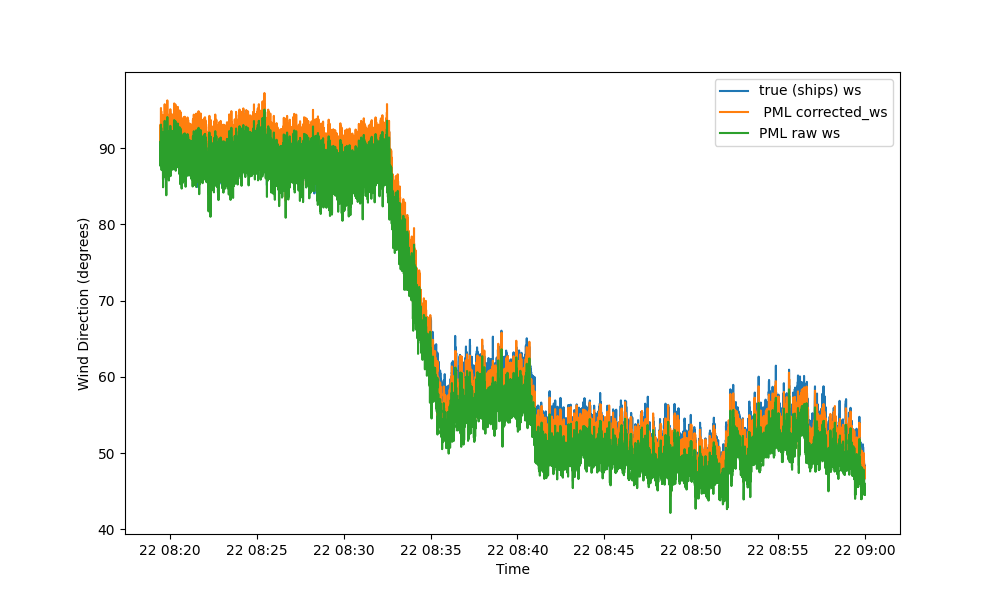

In [ ]:
df_pml_sonic['u_ms'] = pd.to_numeric(df_pml_sonic['u_ms'], errors='coerce')
df_pml_sonic['v_ms'] = pd.to_numeric(df_pml_sonic['v_ms'], errors='coerce')
df_pml_sonic_raw['u_ms'] = pd.to_numeric(df_pml_sonic_raw['u_ms'], errors='coerce')
df_pml_sonic_raw['v_ms'] = pd.to_numeric(df_pml_sonic_raw['v_ms'], errors='coerce')
df_ship_sonic['u_ms_ship'] = pd.to_numeric(df_ship_sonic['u_ms_ship'], errors='coerce')
df_ship_sonic['v_ms_ship'] = pd.to_numeric(df_ship_sonic['v_ms_ship'], errors='coerce')

# Calculate wind direction
df_pml_sonic['wd'] = (270 -np.degrees(np.arctan2(df_pml_sonic['v_ms'], df_pml_sonic['u_ms']))) % 360
df_pml_sonic_raw['wd'] = (270- np.degrees(np.arctan2(df_pml_sonic_raw['v_ms'], df_pml_sonic_raw['u_ms']))) %360
#df_pml_sonic_raw['wd_corrected'] = df_pml_sonic_raw['wd'] - (-1.48)
df_ship_sonic['wd'] = (270 -np.degrees(np.arctan2(df_ship_sonic['v_ms_ship'], df_ship_sonic['u_ms_ship']))) % 360
plt.close('all')    
plt.figure(figsize=(10, 6))
plt.plot(df_ship_sonic.index, df_ship_sonic['wd'], label='true (ships) ws') 
plt.plot(df_pml_sonic.index, df_pml_sonic['wd'], label=' PML corrected_ws') 
#plt.plot(df_pml_sonic_raw.index, df_pml_sonic_raw['wd_corrected'], label='corrected_hand')
plt.plot(df_pml_sonic_raw.index, df_pml_sonic_raw['wd'], label='PML raw ws')  
plt.ylabel('Wind Direction (degrees)')
plt.xlabel('Time')  
plt.legend()
plt.show()

Picarro plots for PICCOLO 

In [126]:
# Initialize list to store data
data_list = []

for i in range(0, len(Picarro_name), 50):
    timestamps = {
        "GPS": extract_timestamp(GPS_name[i]),
        "HDG": extract_timestamp(HDG_name[i]),
        "Picarro": extract_timestamp(Picarro_name[i])
    }
    
    if len(set(timestamps.values())) > 1:
        print(f"Timestamp mismatch at index {i}: {timestamps}")
        continue
    
    # Read and process data as before
    df_gps = read_gps_data(os.path.join(data_dir, 'Underway', GPS_name[i]))
    df_hdg = read_hdg_data(os.path.join(data_dir, 'Underway', HDG_name[i]))
    df_picarro = read_picarro_data(os.path.join(data_dir, 'picarro_hourly', Picarro_name[i]))
    
    # Merge GPS and heading data
    df_underway = pd.merge(df_gps, df_hdg, left_index=True, right_index=True, how="outer")
    df_underway_merged = df_underway.groupby(df_underway.index).agg({
        'latitude': 'first',
        'longitude': 'first',
        'speed': 'first',
        'heading': 'first'
    }).bfill()
    
    # Calculate means
    lat_mean = df_underway_merged['latitude'].mean()
    lon_mean = df_underway_merged['longitude'].mean()
    picarro_mean = df_picarro['CO2_dry_sync'].mean()
    
    # Append to data list
    data_list.append({
        'latitude': lat_mean,
        'longitude': lon_mean,
        'CO2_dry_sync': picarro_mean
    })

# Create final dataframe from all collected data
df_all = pd.DataFrame(data_list)
        
            

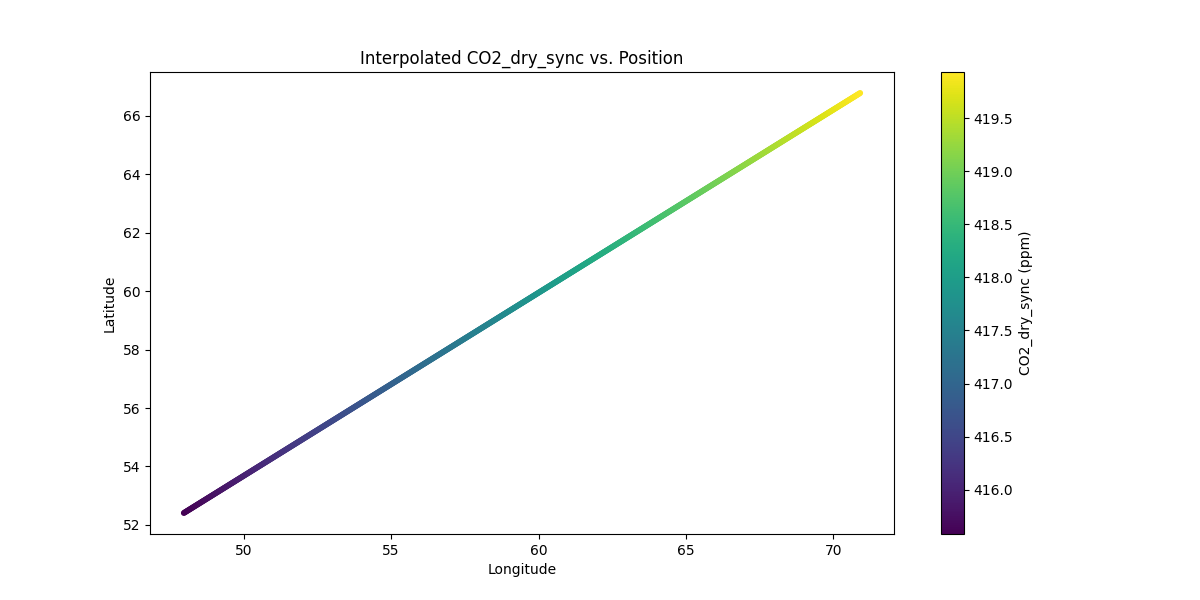

In [130]:
from scipy.interpolate import griddata

# Create new latitude and longitude points with linear spacing
new_lat = np.linspace(df_all['latitude'].min(), df_all['latitude'].max(), 1000)
new_lon = np.linspace(df_all['longitude'].min(), df_all['longitude'].max(), 1000)


co2 = np.linspace(df_all['CO2_dry_sync'].min(), df_all['CO2_dry_sync'].max(), 1000)
    

# Create new interpolated dataframe
df_interpolated = pd.DataFrame({
    'latitude': new_lat.flatten(),
    'longitude': new_lon.flatten(),
    'CO2_dry_sync': co2.flatten()
}).dropna()  # Remove NaN values from interpolation

# Plot the interpolated data
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_interpolated['longitude'], 
                     df_interpolated['latitude'],
                     c=df_interpolated['CO2_dry_sync'],
                     cmap='viridis',
                     marker='o',
                     s=10)  # Smaller point size for denser plot
plt.colorbar(scatter, label='CO2_dry_sync (ppm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Interpolated CO2_dry_sync vs. Position')
plt.show()

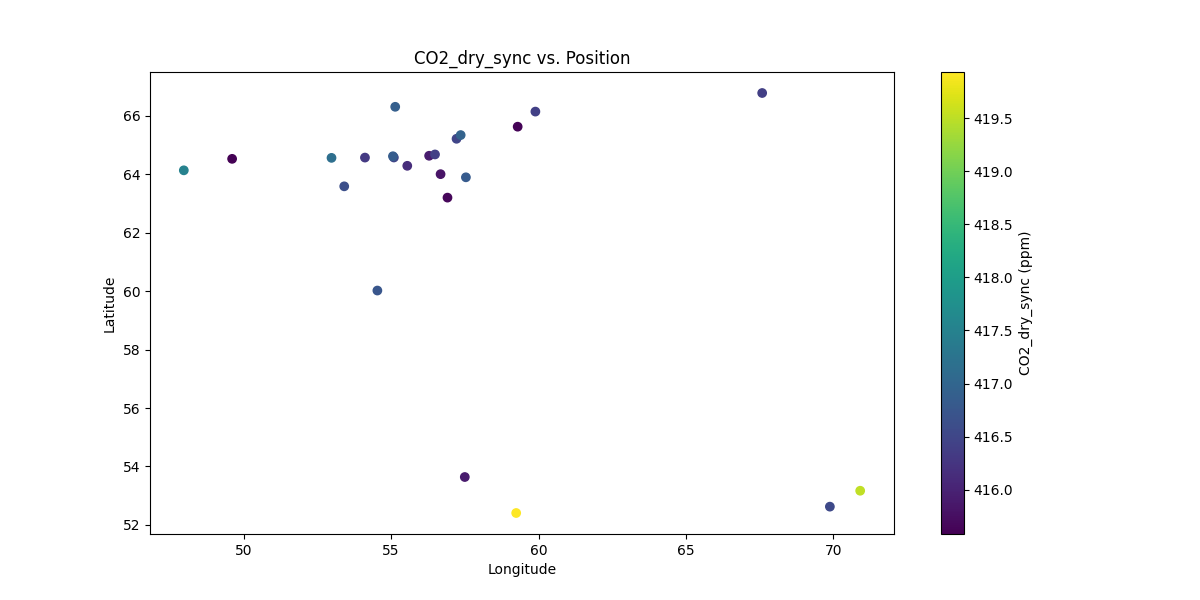

In [127]:
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_all['longitude'], df_all['latitude'], 
					 c=df_all['CO2_dry_sync'], 
					 cmap='viridis', 
					 marker='o')
plt.colorbar(scatter, label='CO2_dry_sync (ppm)')  
plt.xlabel('Longitude')
plt.ylabel('Latitude')  
plt.title('CO2_dry_sync vs. Position')

plt.show()